<a href="https://colab.research.google.com/github/wolframalexa/humanities-data-analysis/blob/main/chap4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# code from book

import csv
import urllib.request

url = 'http://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/4-tables/names.csv'
data = urllib.request.urlopen(url);
lines = [l.decode('utf-8') for l in data.readlines()]
data = list(csv.DictReader(lines))

print(data[0])

OrderedDict([('year', '1880'), ('name', 'Mary'), ('sex', 'F'), ('frequency', '7065')])


In [2]:
# turn frequencies from strings into ints
cleaned_data = []

for row in data:
  row['frequency'] = int(row['frequency'])
  row['year'] = int(row['year'])
  cleaned_data.append(row)

In [3]:
starting_year = min(row['year'] for row in data)
print(starting_year)

ending_year = max(row['year'] for row in data)
print(ending_year)
print("Years covered:", ending_year - starting_year + 1)

1880
2015
Years covered: 136


In [4]:
import collections

# Step 1: create counter objects to store counts of girl and boy names
# See Chapter 2 for an introduction of Counter objects
name_counts_girls = collections.Counter()
name_counts_boys = collections.Counter()

# Step 2: iterate over the data and increment the counters
for row in data:
    if row['sex'] == 'F':
        name_counts_girls[row['year']] += 1
    else:
        name_counts_boys[row['year']] += 1

# Step 3: Loop over all years and assert the presence of at least
# 10 girl and boy names
for year in range(starting_year, ending_year + 1):
    assert name_counts_girls[year] >= 10
    assert name_counts_boys[year] >= 10

In [5]:
# Using Pandas

import pandas as pd

df = pd.read_csv('http://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/4-tables/names.csv')
df.head(n=5)

,year,name,sex,frequency
0,1880,Mary,F,7065
1,1880,Anna,F,2604
2,1880,Emma,F,2003
3,1880,Elizabeth,F,1939
4,1880,Minnie,F,1746


In [6]:
print(df.dtypes)

year          int64
name         object
sex          object
frequency     int64
dtype: object


In [7]:
df['name'].head()

0         Mary
1         Anna
2         Emma
3    Elizabeth
4       Minnie
Name: name, dtype: object

In [8]:
def df2ranking(df, rank_col='frequency', cutoff=20):
    """Transform a data frame into a popularity index."""
    df = df.sort_values(by=rank_col, ascending=False)
    df = df.reset_index()
    return df['name'][:cutoff]

In [9]:
df = pd.read_csv('http://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/4-tables/names.csv')
df = df.set_index('year')

girl_ranks, boy_ranks = [], []
for year in df.index.unique():
    for sex in ('F', 'M'):
        if sex == 'F':
            year_df = df.loc[year]
            year_df.head()
            ranking = df2ranking(year_df.loc[year_df['sex'] == sex])
            ranking.name = year
            girl_ranks.append(ranking)
        else:
            year_df = df.loc[year]
            ranking = df2ranking(year_df.loc[year_df['sex'] == sex])
            ranking.name = year
            boy_ranks.append(ranking)

girl_ranks = pd.DataFrame(girl_ranks)
boy_ranks = pd.DataFrame(boy_ranks)

In [10]:
df.reset_index().groupby('name')['year'].median().sort_values(ascending=False).head()

name
Emere      2015.0
Breayla    2015.0
Milyana    2015.0
Ronza      2015.0
Gennady    2015.0
Name: year, dtype: float64

In [11]:
# old names
df.reset_index().groupby('name')['year'].median().sort_values().head()

name
Roll      1881.0
Zilpah    1881.0
Crete     1881.5
Sip       1885.0
Ng        1885.0
Name: year, dtype: float64

In [12]:
boy_ranks = df.loc[df.sex == 'M'].groupby(level=0).apply(df2ranking)
girl_ranks = df.loc[df.sex == 'F'].groupby(level=0).apply(df2ranking)

In [13]:
def turnover(df):
    """Compute the 'turnover' for popularity rankings."""
    df = df.apply(set, axis=1)
    turnovers = {}
    for year in range(df.index.min() + 1, df.index.max() + 1):
        name_set, prior_name_set = df.loc[year], df.loc[year - 1]
        turnovers[year] = len(name_set.difference(prior_name_set))
    return pd.Series(turnovers)

In [14]:
boy_turnover = turnover(boy_ranks)
boy_turnover.head()

1881    1
1882    1
1883    0
1884    1
1885    0
dtype: int64

In [15]:
def turnover(df):
    """Compute the 'turnover' for popularity rankings."""
    df = df.apply(set, axis=1)
    return (df.iloc[1:] - df.shift(1).iloc[1:]).apply(len)

In [16]:
boy_turnover = turnover(boy_ranks)
girl_turnover = turnover(girl_ranks)
girl_turnover.head()

year
1881    0
1882    2
1883    1
1884    1
1885    0
dtype: int64

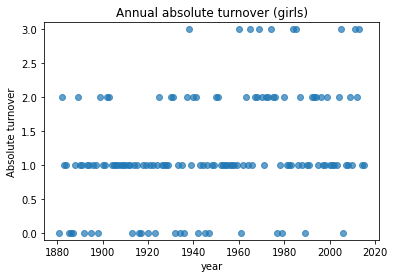

In [17]:
ax = girl_turnover.plot(
    style='o', ylim=(-0.1, 3.1), alpha=0.7,
    title='Annual absolute turnover (girls)'
)
ax.set_ylabel("Absolute turnover");

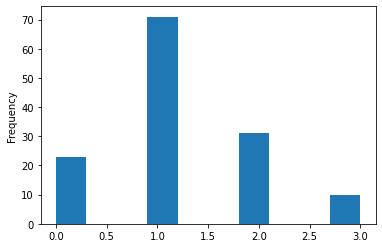

In [18]:
girl_turnover.plot(kind='hist');

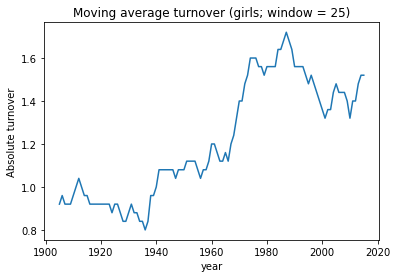

In [19]:
girl_rm = girl_turnover.rolling(25).mean()
ax = girl_rm.plot(title="Moving average turnover (girls; window = 25)")
ax.set_ylabel("Absolute turnover");

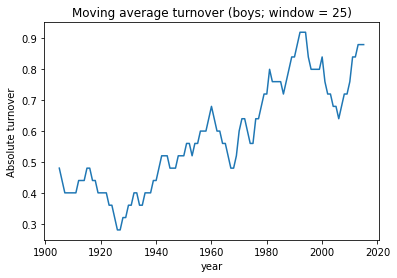

In [20]:
boy_rm = boy_turnover.rolling(25).mean()
ax = boy_rm.plot(title="Moving average turnover (boys; window = 25)")
ax.set_ylabel("Absolute turnover");

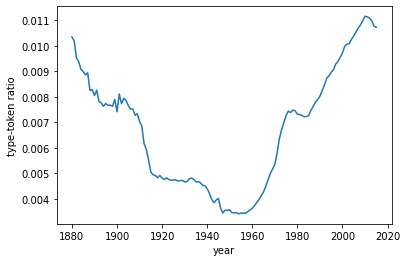

In [21]:
def type_token_ratio(frequencies):
    """Compute the type-token ratio of the frequencies."""
    return len(frequencies) / frequencies.sum()


ax = df.loc[df['sex'] == 'F'].groupby(level=0)['frequency'].apply(type_token_ratio).plot();
ax.set_ylabel("type-token ratio");

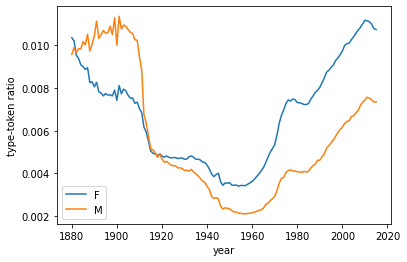

In [22]:
import matplotlib.pyplot as plt

# create an empty plot
fig, ax = plt.subplots()

for sex in ['F', 'M']:
    counts = df.loc[df['sex'] == sex, 'frequency']
    tt_ratios = counts.groupby(level=0).apply(type_token_ratio)
    # Use the same axis to plot both sexes (i.e. ax=ax)
    tt_ratios.plot(label=sex, legend=True, ax=ax)
ax.set_ylabel("type-token ratio");

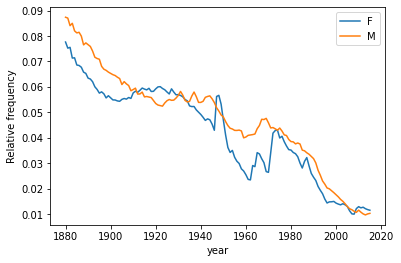

In [23]:
def max_relative_frequency(frequencies):
    return (frequencies / frequencies.sum()).max()

# create an empty plot
fig, ax = plt.subplots()

for sex in ['F', 'M']:
    counts = df.loc[df['sex'] == sex, 'frequency']
    div = counts.groupby(level=0).apply(max_relative_frequency)
    div.plot(label=sex, legend=True, ax=ax)
ax.set_ylabel("Relative frequency");

In [24]:
# boys names ending in n
boys_names = df.loc[df['sex'] == 'M', 'name']
boys_names.str.lower()
boys_coda = boys_names.str.get(-1)
boys_fd = boys_coda.groupby('year').value_counts(normalize=True)
boys_fd.head()

year  name
1880  n       0.181646
      e       0.156102
      s       0.098392
      y       0.095553
      d       0.080416
Name: name, dtype: float64

In [25]:
boys_fd = boys_fd.unstack()
boys_fd.head()


name,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
year,,,,,,,,,,,,,,,,,,,,,,,,,,
1880,0.029328,0.006623,0.006623,0.080416,0.156102,0.006623,0.007569,0.032167,0.003784,NaN,0.018921,0.070009,0.026490,0.181646,0.030274,0.003784,NaN,0.068117,0.098392,0.060549,0.002838,0.000946,0.006623,0.003784,0.095553,0.002838
1881,0.027108,0.006024,0.008032,0.076305,0.148594,0.005020,0.012048,0.033133,0.003012,NaN,0.017068,0.068273,0.026104,0.184739,0.029116,0.006024,NaN,0.072289,0.098394,0.068273,0.002008,0.001004,0.006024,0.005020,0.095382,0.001004
1882,0.025501,0.006375,0.006375,0.080146,0.166667,0.007286,0.008197,0.033698,0.002732,NaN,0.016393,0.070128,0.025501,0.175774,0.030965,0.003643,NaN,0.067395,0.093807,0.062842,0.000911,0.000911,0.007286,0.004554,0.100182,0.002732
1883,0.028183,0.004859,0.006803,0.082604,0.158406,0.006803,0.008746,0.030126,0.001944,NaN,0.016521,0.076774,0.028183,0.176871,0.028183,0.005831,NaN,0.066084,0.099125,0.062196,0.001944,0.000972,0.008746,0.004859,0.094266,0.000972
1884,0.028444,0.008889,0.006222,0.080000,0.155556,0.005333,0.007111,0.031111,0.001778,NaN,0.017778,0.065778,0.024889,0.186667,0.027556,0.004444,NaN,0.073778,0.097778,0.061333,0.001778,0.000889,0.006222,0.003556,0.100444,0.002667


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/style.py:64: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  [conv.to_rgba(c) for c in colors]


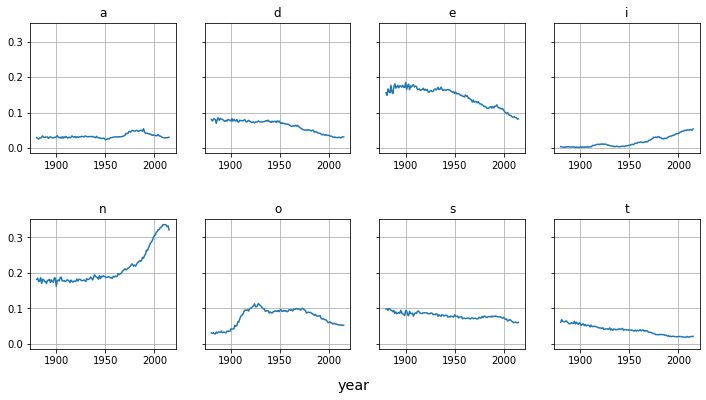

In [26]:
fig, axes = plt.subplots(
    nrows=2, ncols=4, sharey=True, figsize=(12, 6))

letters = ["a", "d", "e", "i", "n", "o", "s", "t"]
axes = boys_fd[letters].plot(
    subplots=True, ax=axes, title=letters, color='C0', grid=True, legend=False)

# The x-axis of each subplots is labeled with 'year'.
# We remove those and add one main x-axis label
for ax in axes.flatten():
    ax.xaxis.label.set_visible(False)
fig.text(0.5, 0.04, "year", ha="center", va="center", fontsize="x-large")
# Reserve some additional height for space between subplots
fig.subplots_adjust(hspace=0.5);

In [27]:
# Unisex names in the US

def usage_ratio(df):
    """Compute the usage ratio for unixes names."""
    df = df.loc[df.duplicated(subset='name', keep=False)]
    df = df.pivot_table(values='frequency', index='name', columns='sex')
    return df['F'] / (df['F'] + df['M'])

d = df.groupby(level=0).apply(usage_ratio)
d.head()

year  name 
1880  Addie    0.971631
      Allie    0.772059
      Alma     0.951890
      Alpha    0.812500
      Alva     0.195402
dtype: float64

In [28]:
d = d.unstack(level='name')
d.tail()

name,Aaden,Aadi,Aadyn,Aalijah,Aaliyah,Aamari,Aamir,Aaren,Aarian,Aarin,Aarion,Aaris,Aaron,Aarya,Aaryan,Aaryn,Aayden,Abbey,Abbie,Abbigail,Abbott,Abby,Abdi,Abeer,Abel,Abey,Abi,Abie,Abiel,Abigael,Abigail,Abigayle,Abijah,Abiola,Abir,Abisai,Abishai,Abraham,Abrar,Abriel,...,Zi,Zia,Ziah,Ziaire,Zian,Ziare,Ziel,Ziggy,Zihan,Zikora,Zimri,Zina,Zion,Zixuan,Ziya,Ziyah,Ziyan,Ziyi,Ziyon,Zo,Zoe,Zoel,Zoey,Zohar,Zola,Zollie,Zong,Zora,Zuri,Zuriah,Zuriel,Zyah,Zyair,Zyaire,Zyan,Zyian,Zyien,Zyion,Zyon,Zyree
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011,NaN,NaN,NaN,0.318182,NaN,0.428571,NaN,NaN,NaN,NaN,NaN,NaN,0.002752,0.878049,NaN,0.583333,0.032895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005291,NaN,NaN,NaN,NaN,NaN,0.998416,NaN,0.384615,NaN,0.26087,NaN,NaN,NaN,0.581395,0.477273,...,NaN,0.872000,0.681818,0.161290,0.282051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245195,NaN,NaN,NaN,0.695652,NaN,0.194030,NaN,0.997781,NaN,0.998127,NaN,NaN,NaN,NaN,NaN,0.939940,NaN,0.131579,NaN,0.187500,0.154206,0.220779,0.571429,NaN,0.153153,0.155080,NaN
2012,NaN,0.081967,NaN,0.333333,0.998729,NaN,NaN,NaN,0.333333,0.187500,NaN,NaN,0.002785,0.891304,NaN,0.581818,NaN,NaN,NaN,NaN,0.113636,NaN,NaN,0.533333,NaN,NaN,0.782609,NaN,0.101695,NaN,0.998976,NaN,0.538462,NaN,NaN,NaN,0.545455,0.002558,0.645161,0.531250,...,NaN,0.889655,0.829268,NaN,0.162162,NaN,0.454545,NaN,NaN,0.375,NaN,NaN,0.188098,NaN,NaN,NaN,0.529412,NaN,0.120000,NaN,0.997369,NaN,0.998795,0.437500,NaN,NaN,NaN,NaN,0.960177,NaN,0.244186,NaN,0.131148,0.177083,0.161290,0.470588,NaN,0.144737,0.257426,NaN
2013,NaN,0.078947,NaN,0.500000,0.997705,0.333333,0.042553,NaN,0.208333,NaN,NaN,NaN,0.001507,0.882979,0.053571,0.775000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.545455,0.003125,NaN,NaN,NaN,0.071429,NaN,0.998710,NaN,0.307692,0.5,NaN,NaN,NaN,0.002706,0.631579,0.212766,...,NaN,0.894040,0.647059,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.177044,NaN,NaN,0.884615,0.500000,NaN,0.222222,NaN,0.997492,0.357143,0.998756,0.538462,NaN,NaN,NaN,NaN,0.975862,NaN,0.220930,NaN,0.138889,0.168269,0.260274,NaN,NaN,0.225352,0.147239,0.5
2014,NaN,NaN,NaN,0.363636,0.998975,0.400000,NaN,NaN,0.350000,0.166667,0.227273,0.5,0.003112,0.894472,NaN,0.642202,NaN,NaN,NaN,NaN,0.145455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998922,NaN,NaN,NaN,NaN,0.288889,0.380952,0.004205,0.659091,0.311475,...,NaN,0.903704,0.837209,NaN,NaN,NaN,NaN,0.12,NaN,NaN,NaN,NaN,0.166949,0.444444,NaN,0.888889,0.400000,NaN,0.145833,0.6875,0.996427,NaN,0.998513,0.428571,NaN,NaN,NaN,NaN,0.982249,NaN,0.313869,NaN,0.108108,0.123711,0.268657,NaN,NaN,0.197802,0.209790,NaN
2015,NaN,NaN,NaN,0.413793,0.998967,0.562500,NaN,NaN,0.380952,NaN,0.318182,NaN,0.002524,0.900000,NaN,0.613333,NaN,NaN,NaN,NaN,0.117647,NaN,NaN,0.526316,0.003100,NaN,NaN,NaN,NaN,NaN,0.999351,NaN,0.473684,NaN,NaN,0.302326,0.375000,0.002470,0.484848,0.290909,...,NaN,0.901408,0.775862,0.192308,0.170732,NaN,NaN,NaN,0.615385,NaN,NaN,NaN,0.153691,0.461538,0.885246,NaN,0.541667,0.5,0.151515,NaN,0.997504,0.545455,0.997975,0.736842,NaN,NaN,NaN,NaN,0.979282,NaN,0.246575,0.75,0.098592,0.107981,0.156250,NaN,NaN,0.094595,0.164773,NaN


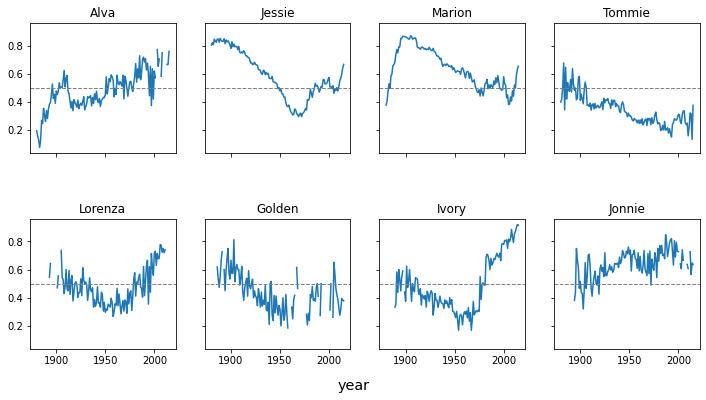

In [29]:
unisex_ranking = abs(d - 0.5).fillna(0.5).mean().sort_values().index

# Create a figure and subplots
fig, axes = plt.subplots(
    nrows=2, ncols=4, sharey=True, sharex=True, figsize=(12, 6))

# Plot the time series into the subplots
names = unisex_ranking[:8].tolist()
d[names].plot(
    subplots=True, color="C0", ax=axes, legend=False, title=names)

# Clean up some redudant labels and adjust spacing
for ax in axes.flatten():
    ax.xaxis.label.set_visible(False)
    ax.axhline(0.5, ls='--', color="grey", lw=1)
fig.text(0.5, 0.04, "year", ha="center", va="center", fontsize="x-large");
fig.subplots_adjust(hspace=0.5);

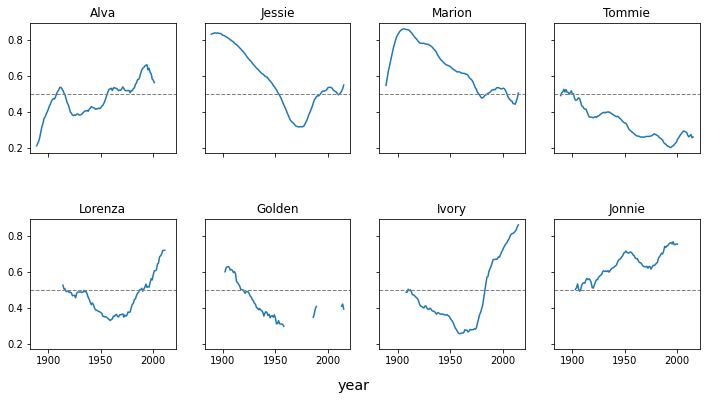

In [30]:
# Create a figure and subplots
fig, axes = plt.subplots(
    nrows=2, ncols=4, sharey=True, sharex=True, figsize=(12, 6))

# Plot the time series into the subplots
d[names].rolling(window=10).mean().plot(
    color='C0', subplots=True, ax=axes, legend=False, title=names);

# Clean up some redundant labels and adjust spacing
for ax in axes.flatten():
    ax.xaxis.label.set_visible(False)
    ax.axhline(0.5, ls='--', color="grey", lw=1)
fig.text(0.5, 0.04, "year", ha="center", va="center", fontsize="x-large");
fig.subplots_adjust(hspace=0.5);

# closer to 1 = more girls, closer to 0 = more boys

In [31]:
# my code
# Easy
df = pd.read_csv('http://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/4-tables/names.csv')
df = df.set_index('year')
df.shape # 1858436 rows


(1858436, 3)

In [111]:
girl_rows = df[(df['sex'] == 'F')]
print(len(girl_rows))
boy_rows = df[(df['sex'] == 'M')]
print(len(boy_rows))

1100738
757698


In [33]:
girl_rows.value_counts().shape
# there are more unique girl names than unique boy names

(613857,)

In [34]:
boy_rows.value_counts().shape

(400189,)

In [35]:
grouped_girls = girl_rows.groupby('name')
top_girl_names = 0

for grouper, group in grouped_girls:
    freq = group.sum()['frequency']
    if freq > 100:
      top_girl_names += 1
print(top_girl_names)

23903


In [36]:
grouped_boys = boy_rows.groupby('name')
top_boy_names = 0

for grouper, group in grouped_boys:
    freq = group.sum()['frequency']
    if freq > 100:
      top_boy_names += 1

In [37]:
print(top_boy_names)
# more frequent girl than boy names - probably the distribution of girl names is
# far more skewed than boy names, since girls have both more unique names and 
# more common names.

14943


In [38]:
# Moderate

#  names ending in n
girl_names = df.loc[df['sex'] == 'F', 'name']
girl_names.str.lower()
girl_coda = girl_names.str.get(-1)
girl_fd = girl_coda.groupby('year').value_counts(normalize=True)
girl_fd.head()

girl_fd = girl_fd.unstack()
girl_fd.head()


name,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
year,,,,,,,,,,,,,,,,,,,,,,,,,,
1880,0.444798,NaN,NaN,0.008493,0.345011,NaN,0.001062,0.027601,0.003185,NaN,0.001062,0.025478,0.002123,0.031847,0.003185,NaN,NaN,0.018047,0.022293,0.012739,0.002123,NaN,NaN,NaN,0.049894,0.001062
1881,0.431770,NaN,NaN,0.009595,0.358209,NaN,0.001066,0.027719,0.003198,NaN,0.002132,0.031983,0.002132,0.030917,0.005330,NaN,NaN,0.011727,0.019190,0.010661,0.002132,NaN,0.001066,NaN,0.050107,0.001066
1882,0.437743,NaN,0.000973,0.007782,0.345331,NaN,0.000973,0.032101,0.002918,NaN,0.000973,0.030156,0.003891,0.029183,0.002918,NaN,NaN,0.012646,0.020428,0.013619,0.001946,NaN,NaN,NaN,0.055447,0.000973
1883,0.427894,NaN,0.000949,0.010436,0.359583,NaN,0.000949,0.028463,0.001898,NaN,0.000949,0.026565,0.003795,0.029412,0.003795,NaN,NaN,0.017078,0.018975,0.014231,0.001898,NaN,NaN,0.000949,0.051233,0.000949
1884,0.436007,NaN,NaN,0.009386,0.348976,NaN,0.001706,0.031570,0.001706,NaN,0.000853,0.029010,0.001706,0.029010,0.005119,NaN,NaN,0.014505,0.019625,0.011945,0.001706,NaN,NaN,NaN,0.056314,0.000853


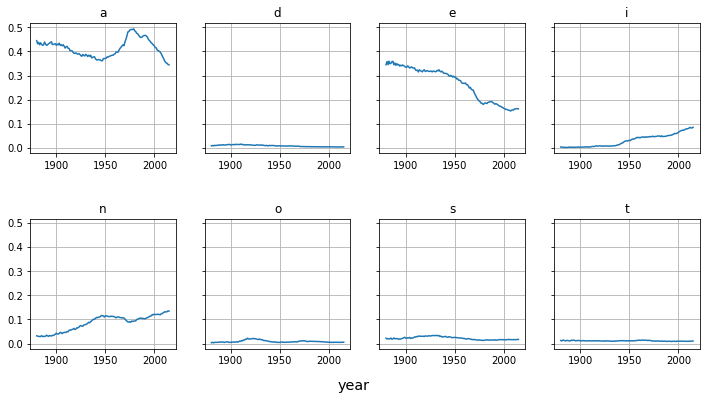

In [39]:
fig, axes = plt.subplots(
    nrows=2, ncols=4, sharey=True, figsize=(12, 6))

letters = ["a", "d", "e", "i", "n", "o", "s", "t"]
axes = girl_fd[letters].plot(
    subplots=True, ax=axes, title=letters, color='C0', grid=True, legend=False)

# The x-axis of each subplots is labeled with 'year'.
# We remove those and add one main x-axis label
for ax in axes.flatten():
    ax.xaxis.label.set_visible(False)
fig.text(0.5, 0.04, "year", ha="center", va="center", fontsize="x-large")
# Reserve some additional height for space between subplots
fig.subplots_adjust(hspace=0.5);

The ending "a" for young girls has historically been very popular, but has dipped slightly in recent years, with "n" and "i" picking up a little of the decrease. The ending "e" is also in decline and has been since the start of the dataset. 

In [40]:
# Which names used now and in the past

def timespan(x):
  # takes series object and returns difference between max & min
  # confusion: how is this related to the "timespan" - seems to only have to do 
  # with name popularity rather than time?

  return(max(x['frequency']) - min(x['frequency']))

# five names with "longest timespan"
df.groupby('name').apply(timespan).sort_values(ascending=False).head()

name
Linda      99675
James      94745
Michael    92721
Robert     91639
John       88315
dtype: int64

In [41]:
def longest_name(x):
  length = x.str.len()
  return(max(length))

def mean_name(x):
  length = x.str.len()
  return(sum(length)/len(length))

# df.groupby('year').apply(longest_name).sort_values(ascending=False).head()

f_max = girl_rows.groupby('year').name.apply(longest_name)
f_mean = girl_rows.groupby('year').name.apply(mean_name)

m_max = boy_rows.groupby('year').name.apply(longest_name)
m_mean = boy_rows.groupby('year').name.apply(mean_name)

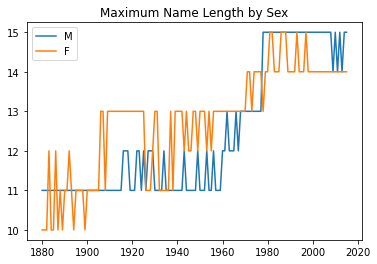

In [42]:
fig, ax = plt.subplots()

ax.plot(m_max)
ax.plot(f_max)
plt.title("Maximum Name Length by Sex")
ax.legend(["M", "F"])

Names for girls were longer than names for boys in the mid 19th century, but long names for boys are now more common. This might owe to patterns of immigration from cultures where boys are given longer names.

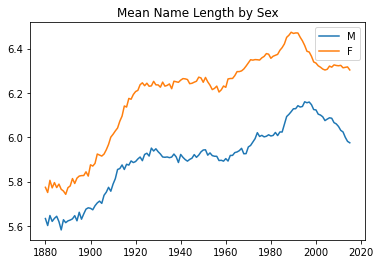

In [43]:
fig, ax = plt.subplots()

ax.plot(m_mean)
ax.plot(f_mean)
plt.title("Mean Name Length by Sex")
ax.legend(["M", "F"])

On average, though, female names have remained longer than male names, but the overall trends mirror each other in terms of name length, both increasing sharply around 1910 and declining since 2000.

In [44]:
# Challenging

def num_vowels(string):
  # returns the number of vowels in a string
  vowels = "aeiouyAEIOUY"
  count = 0

  for char in string:
    if char in vowels:
      count += 1
  return(count)



In [46]:
girls8 = girl_names[girl_names.apply(num_vowels) == 8].unique()
print("Girls with 8 vowels in their name:", girls8)

Girls with 8 vowels in their name: ['Mariaguadalupe' 'Mariadelrosario' 'Oluwafunmilayo' 'Aaliyahmarie'
 'Moyosoreoluwa' 'Oluwaseyifunmi' 'Oluwafikayomi']


In [59]:
avg_vowels_girls = sum(girl_names.apply(num_vowels))/len(girl_names)
print("On average, girls' names have", avg_vowels_girls, "vowels.")

avg_vowels_boys = sum(boys_names.apply(num_vowels))/len(boys_names)
print("On average, boys' names have", avg_vowels_boys, "vowels.")

On average, girls' names have 2.9955884143183935 vowels.
On average, boys' names have 2.5312512373003493 vowels.


Girls have more vowels than boys - this difference seems significant to me, since names filled with vowels may be more associated with femininity vs masculinity.

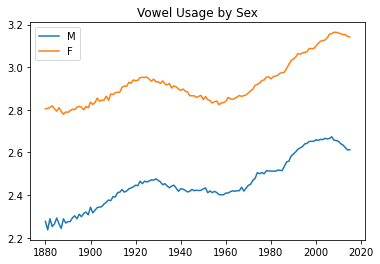

In [69]:
def average(x):
  return(sum(x)/len(x))

girl_vowels = girl_names.apply(num_vowels).groupby('year').apply(average)
boy_vowels = boys_names.apply(num_vowels).groupby('year').apply(average)

fig, ax = plt.subplots()

ax.plot(boy_vowels)
ax.plot(girl_vowels)
plt.title("Vowel Usage by Sex")
ax.legend(["M", "F"])

The trends of vowel usage for girls and boys are similar, but girls' are always approximately .5 larger than boys'.

In [122]:
# split people by first initial
from collections import Counter    

# get distinct names
girl_names_unique = girl_rows.name.unique()
initials = [item[0] for item in girl_names_unique]

sorted_dict = dict(sorted(dict(Counter(initials)).items()))
girl_initials = list(sorted_dict.values()) # messy typecasting
print(girl_initials) # number of distinct names with a certain initial

[7381, 2234, 4137, 3899, 2436, 832, 1390, 1127, 1050, 4596, 4905, 4440, 5507, 2476, 708, 1079, 274, 2784, 6022, 4264, 165, 1078, 561, 145, 1054, 1113]


In [121]:
# get number of people with each initial
# girl_start = girl_rows
girl_start['name'] = girl_rows['name'].str.get(0)
all_girls = girl_start.groupby('name').frequency.apply(sum)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [129]:
# get distinct names
boys_names_unique = boy_rows.name.unique()
boys_initials = [item[0] for item in boys_names_unique]

sorted_dict = dict(sorted(dict(Counter(boys_initials)).items()))
boys_initials = list(sorted_dict.values()) # messy typecasting
print(boys_initials) # number of distinct names with a certain initial

[3512, 1670, 2244, 3357, 1517, 584, 1083, 1107, 561, 3952, 3029, 1782, 2608, 1161, 714, 657, 295, 2085, 2493, 2567, 148, 550, 568, 124, 555, 804]


In [135]:
boy_start = boy_rows.copy(deep=True)
boy_start['name'] = boy_rows['name'].str.get(0)
all_boys = boy_start.groupby('name').frequency.apply(sum)

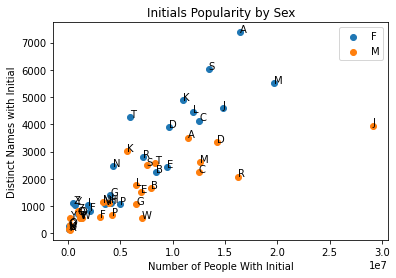

In [138]:
import string

letters = list(string.ascii_uppercase)
fig, ax = plt.subplots()

ax.scatter(all_girls, girl_initials)
ax.scatter(all_boys, boys_initials)
i = 0 

for letter in letters:
  plt.annotate(letter, xy=(all_girls[i], girl_initials[i]))
  plt.annotate(letter, xy=(all_boys[i], boys_initials[i]))
  i += 1

plt.xlabel("Number of People With Initial")
plt.ylabel("Distinct Names with Initial")
plt.title("Initials Popularity by Sex")
ax.legend(["F", "M"])

In [167]:
def return_data(rows):
  # performs the above, in a function

  # get distinct names
  names_unique = rows.name.unique()
  initials = [item[0] for item in names_unique]

  sorted_dict = dict(sorted(dict(Counter(initials)).items()))
  initials = list(sorted_dict.values()) # messy typecasting

  # get number of people with each initial
  start = rows.copy()
  start['name'] = rows['name'].str.get(0)
  all = start.groupby('name').frequency.apply(sum)

  return(all, initials)

In [168]:
# Girls 1900-1920
girls0020 = girl_rows[(girl_rows['year'] >= 1900) & (girl_rows['year'] <= 1920)]
allgirls0020, initials_f0020 = return_data(girls0020)

# Boys 1900-1920
boys0020 = boy_rows[(boy_rows['year'] >= 1900) & (boy_rows['year'] <= 1920)]
allboys0020, initials_m0020 = return_data(boys0020)

# Girls 1980-2000
girls8000 = girl_rows[(girl_rows['year'] >= 1980) & (girl_rows['year'] <= 2000)]
allgirls8000, initials_f8000 = return_data(girls8000)

# Boys 1980-2000
boys8000 = boy_rows[(boy_rows['year'] >= 1900) & (boy_rows['year'] <= 1920)]
allboys8000, initials_m8000 = return_data(boys8000)

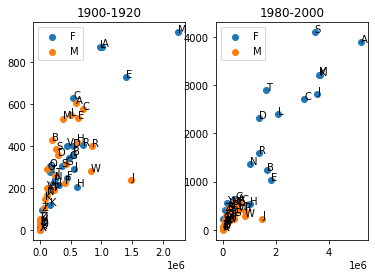

In [183]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(allgirls0020, initials_f0020)
ax1.scatter(allboys0020, initials_m0020)
  
ax2.scatter(allgirls8000, initials_f8000)
ax2.scatter(allboys8000, initials_m8000)

letters = list(string.ascii_uppercase)
i = 0 

for letter in letters:
  ax1.annotate(letter, xy=(allgirls0020[i], initials_f0020[i]))
  ax1.annotate(letter, xy=(allboys0020[i], initials_m0020[i]))

  ax2.annotate(letter, xy=(allgirls8000[i], initials_f8000[i]))
  ax2.annotate(letter, xy=(allboys8000[i], initials_m8000[i]))
  i += 1


ax1.title.set_text("1900-1920")
ax2.title.set_text("1980-2000")
ax1.legend(["F", "M"])
ax2.legend(["F", "M"])

Both the letters themselves and the patters changed between the turn of the century and the end. Towards the end of the century, there were more people (because of population growth - we did not normalize this plot), so there are more names and more people with each initial. Towards the end of the century, though, there are comparatively fewer distinct names for unpopular initials (see the cluster in the lower left).